In [3]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from models.lstm import LSTMRegressor
from models.kangru import KANGRU
from utils.stock_data import get_log_return_loaders, StockIndex
from utils.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [4]:
stock = StockIndex.NVDA
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=32
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.001204 | Val Loss = 0.000704
Epoch 2: Train Loss = 0.001115 | Val Loss = 0.000694
Epoch 3: Train Loss = 0.001110 | Val Loss = 0.000692
Epoch 4: Train Loss = 0.001114 | Val Loss = 0.000735
Epoch 5: Train Loss = 0.001112 | Val Loss = 0.000802
Epoch 6: Train Loss = 0.001113 | Val Loss = 0.000694
Epoch 7: Train Loss = 0.001112 | Val Loss = 0.000703
Epoch 8: Train Loss = 0.001111 | Val Loss = 0.000709
Epoch 9: Train Loss = 0.001089 | Val Loss = 0.000693
Epoch 10: Train Loss = 0.001086 | Val Loss = 0.000694
2.8604650497436523


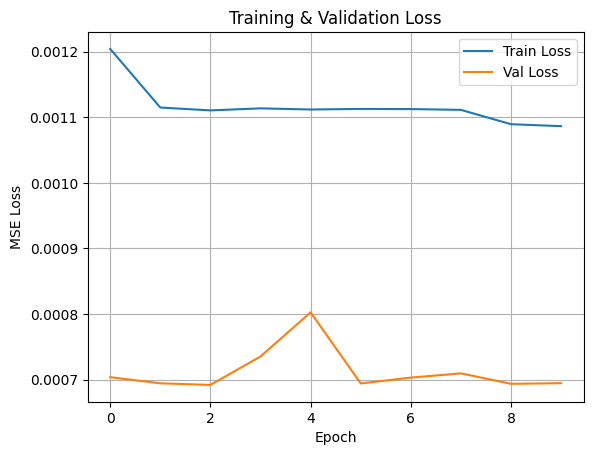

In [7]:
nvda_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=192,
    num_layers=3,
    dropout=0.22832671613107025
).to(device)

optimizer = optim.Adam(nvda_model.parameters(), lr=0.001025807645705379)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []
start = time.time()
for epoch in range(10):
    # ---- TRAIN ----
    nvda_model.train()
    train_loss = 0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(nvda_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    nvda_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(nvda_model(xb).squeeze(), yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
print(time.time()-start)
# Plot training + validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
model = KANGRU(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    device=device,
    grid=13,
    k=2,
)

# best params taken from the tuning process
start = time.time()
# --- Train ---
model.fit(train_dl, val_dl=val_dl, steps=10,
          patience=15,
          lr=0.006606998028725651,
          lamb=0.0008251731794814873,
          lamb_entropy = 0.24267972801572674,
          lamb_l1 = 1.311260552687473,
          lamb_coef = 2.9275528404866757e-05,
          lamb_coefdiff = 1.6257343048503087e-05,
          warmup_steps=5
         )
print(time.time()-start)

Step 9 | MSE: 8.88e-04 | Reg: 2.91e+01 | Total: 2.49e-02 | Val MSE: 6.75e-04: 100%|█| 10/10 [00:37<00:00,  3.7

37.43151044845581


In [10]:
print("LSTM param count:", sum(p.numel() for p in nvda_model.parameters() if p.requires_grad))
print("KANGRU param count:", sum(p.numel() for p in model.parameters() if p.requires_grad))


LSTM param count: 748993
KANGRU param count: 656129
